# Marian notebook


Load la data comme dans baseline


In [251]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge





from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack
import nltk# cant't find the stopword corpus otherwise
nltk.download('stopwords')
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt



# Load the training data
train_data = pd.read_csv("data/train.csv")

# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)

# You can examine the available features using X_train.head()
X_train.head()#le premier numero correspond au no de la ligne dans le csv



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data cleaning


Feature selection
- mentions is always empty -> DROP Mention
- url -> can't be used as plain text -> should count the number of URLs in URLs_count
- hashtags -> first: count the number of hashtags in hashtags_count
            -> second: build a graph

- remove tweetID -> TO DO

# First regressor


### Data processing


Contenu texte du tweet: NAN?????

In [ ]:
# We set up an Tfidf Vectorizer that will use the top 100 tokens from the tweets. We also remove stopwords.
# To do that we have to fit our training dataset and then transform both the training and testing dataset. 
vectorizer = TfidfVectorizer(max_features=10, stop_words=stopwords.words('french'))
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_tfidf = vectorizer.transform(X_test['text'])


# We convert the dense matrix to a dataframe
X_train_tfidf = pd.DataFrame(X_train_tfidf.todense(), columns=vectorizer.get_feature_names())
X_test_tfidf = pd.DataFrame(X_test_tfidf.todense(), columns=vectorizer.get_feature_names())

#set X_train_tfidf values as float32
X_train_tfidf = X_train_tfidf.astype('float32')
X_test_tfidf = X_test_tfidf.astype('float32')

print(X_train_tfidf.head())
print(type(X_train_tfidf))
# We add the tfidf features to our training and testing dataset
#X_train = pd.concat([X_train, X_train_tfidf], axis=1)
#X_test = pd.concat([X_test, X_test_tfidf], axis=1)

   ans  faire  france  français  gauche    macron  président   rt  vote  \
0  0.0    0.0     0.0  0.731333     0.0  0.411827        0.0  0.0   0.0   
1  0.0    0.0     0.0  0.000000     0.0  0.000000        0.0  0.0   1.0   
2  0.0    0.0     0.0  0.000000     0.0  0.000000        0.0  1.0   0.0   
3  0.0    0.0     0.0  0.000000     0.0  1.000000        0.0  0.0   0.0   
4  0.0    0.0     0.0  0.000000     1.0  0.000000        0.0  0.0   0.0   

    zemmour  
0  0.543646  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
<class 'pandas.core.frame.DataFrame'>


Autres features vectorisées

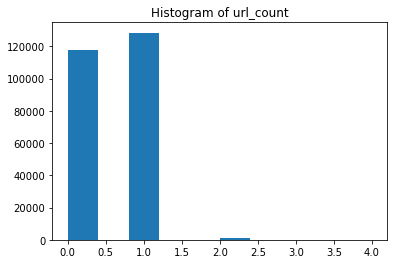

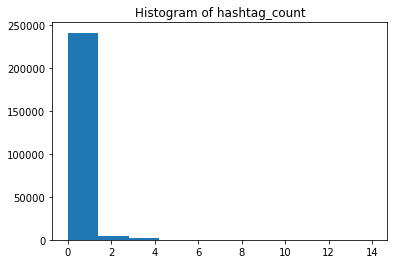

In [ ]:
#mentions is always empty -> DROP Mention

X_train = X_train.drop(['mentions'], axis=1)
X_test = X_test.drop(['mentions'], axis=1)

#add a column to data which counts url
X_train['url_count'] = X_train['urls'].str.count('http')
X_test['url_count'] = X_test['urls'].str.count('http')
X_train = X_train.drop(['urls'], axis=1)
X_test = X_test.drop(['urls'], axis=1)
#make a visualization of url_count
plt.hist(X_train['url_count'], bins=10)
plt.title("Histogram of url_count")
plt.show()



#add a column to data which counts words in hashtags
X_train['hashtag_count'] = X_train['hashtags'].str.count(' ')
X_test['hashtag_count'] = X_test['hashtags'].str.count(' ')
X_train = X_train.drop(['hashtags'], axis=1)
X_test = X_test.drop(['hashtags'], axis=1)
#make a visualization of hashtag_count
plt.hist(X_train['hashtag_count'], bins=10)
plt.title("Histogram of hashtag_count")
plt.show()




#drop the text column
X_train = X_train.drop(['text'], axis=1)
X_test = X_test.drop(['text'], axis=1)






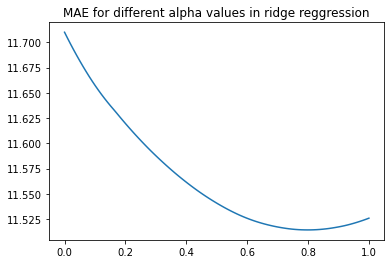

<Figure size 2160x4320 with 0 Axes>

Prediction error Gradient Boosting: 6.782806452524225


KeyboardInterrupt: 

In [ ]:

# Now we can train our model.  we set our loss function 

#plot linear regression result with LASSO regularization with alpha between 0 and 1
alpha = np.linspace(0, 1, 100)
mae = []
for a in alpha:
    reg = Lasso(alpha=a)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mae.append(mean_absolute_error(y_test, y_pred))
plt.plot(alpha, mae)
plt.title("MAE for different alpha values in LASSO reggression")
#size of the plot
plt.figure(figsize=(100,200))
plt.show()

#plot linear regression result with ridge regularization with alpha between 0 and 1
alpha = np.linspace(0, 1, 100)
mae = []
for a in alpha:
    reg = Ridge(alpha=a)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mae.append(mean_absolute_error(y_test, y_pred))
plt.plot(alpha, mae)
plt.title("MAE for different alpha values in RIDGE reggression")
#size of the plot
plt.figure(figsize=(100,200))
plt.show()

reg1 = GradientBoostingRegressor()
reg2 = RandomForestRegressor() 


# We fit our model using the training data
reg1.fit(X_train, y_train)
# And then we predict the values for our testing set
y_pred = reg1.predict(X_test)
# We want to make sure that all predictions are non-negative integers
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]

print("Prediction error Gradient Boosting:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

# We fit our model using the training data
reg2.fit(X_train, y_train)
# And then we predict the values for our testing set
y_pred = reg2.predict(X_test)
# We want to make sure that all predictions are non-negative integers
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]

print("Prediction error Random Forest:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

